In [1]:
# Jason's implementation of directional algo
from algorithim import Params, Algorithm, Capon

import os
os.environ['DRJIT_LIBLLVM_PATH'] = '/usr/lib/x86_64-linux-gnu/libLLVM.so:'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import os # Configure which GPU

if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0 # Use "" to use the CPU
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
    print(f"Using GPU {gpu_num}")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))
gpus = tf.config.list_physical_devices('GPU')
print(f"Found {len(gpus)} GPUs")
if gpus:
    print(f"Found GPU: {gpus[0].name}")
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

# Colab does currently not support the latest version of ipython.
# Thus, the preview does not work in Colab. However, whenever possible we
# strongly recommend to use the scene preview mode.
try: # detect if the notebook runs in Colab
    import google.colab
    no_preview = True # deactivate preview
except:
    if os.getenv("SIONNA_NO_PREVIEW"):
        no_preview = True
    else:
        no_preview = False

resolution = [480,320] # increase for higher quality of renderings

# Define magic cell command to skip a cell if needed
from IPython.core.magic import register_cell_magic
from IPython import get_ipython

@register_cell_magic
def skip_if(line, cell):
    if eval(line):
        return
    get_ipython().run_cell(cell)

# Set random seed for reproducibility
sionna.config.seed = 42

2025-01-20 07:40:34.509742: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737387634.520941 2502860 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737387634.524251 2502860 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-20 07:40:34.536618: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
jit_find_library(): Unable to load "/usr/lib/x86_64-linux-gnu/libLLVM.so:": /usr/lib/x86_64-linux-gnu/libLLVM.so:: cannot ope

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Found 1 GPUs
Found GPU: /physical_device:GPU:0


I0000 00:00:1737387636.070057 2502860 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 18797 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:2b:00.0, compute capability: 8.6


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time

# Import Sionna RT components
from sionna.rt import load_scene, Transmitter, Receiver, PlanarArray, Camera, AntennaArray, Antenna

# For link-level simulations
from sionna.channel import cir_to_ofdm_channel, subcarrier_frequencies, OFDMChannel, ApplyOFDMChannel, CIRDataset
from sionna.nr import PUSCHConfig, PUSCHTransmitter, PUSCHReceiver
from sionna.utils import compute_ber, ebnodb2no, PlotBER
from sionna.ofdm import KBestDetector, LinearDetector
from sionna.mimo import StreamManagement
from sionna.ofdm import ResourceGrid

def calculate_heading(start, end):
    # Calculate the difference vector
    diff = np.array(end) - np.array(start)
    
    # Calculate the heading angle in radians
    heading = np.arctan2(diff[1], diff[0])
    
    # Convert the heading angle to degrees
    # heading_degrees = np.degrees(heading)
    
    return heading

def get_rss_from_csi(csi):
  # Compute CSI power (power per subcarrier)
  csi_power = tf.abs(csi)**2

  # Compute RSS per receiver-transmitter pair (sum over subcarriers)
  rss_per_rx_tx = tf.reduce_sum(csi_power, axis=-1)  # Sum over subcarriers

  # Convert RSS from linear scale (e.g., Watts) to dBm
  rss_per_rx_tx_dBm = 10 * tf.math.log(rss_per_rx_tx / 1e-3) / tf.math.log(10.0)

  return rss_per_rx_tx_dBm

def dbm_to_watts(dbm):
    return 10. ** ((dbm-30)/10)

def watts_to_dbm(watts):
    epsilon = 1e-10  # Small constant to avoid log(0)
    return 10 * np.log10(watts + epsilon) + 30

In [3]:
SCENE_NAME = "canyon"
IMAGE_FOLDER = f"images/{SCENE_NAME}"

# os.environ['DRJIT_LIBLLVM_PATH'] = '/usr/lib/x86_64-linux-gnu/libLLVM.so:'
# os.environ['LD_LIBRARY_PATH'] = '/usr/lib/llvm-14/lib'
# Load integrated scene
scene = load_scene(f"models/{SCENE_NAME}.xml") # Try also sionna.rt.scene.etoile
# scene = load_scene(sionna.rt.scene.simple_wedge)

In [4]:
# Configure antenna array for all transmitters
scene.tx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="iso",
                             polarization="V")

# To visualize the antenna array
# scene.tx_array.show()

# # Configure antenna array for all receivers
# scene.rx_array = PlanarArray(num_rows=1,
#                              num_cols=1,
#                              vertical_spacing=0.5,
#                              horizontal_spacing=0.5,
#                              pattern="iso",
#                              polarization="V")

# # Multiple Antennas like ASUS Router
RelativeAntennas = AntennaArray(antenna=Antenna("dipole", "V"), 
                            positions=tf.Variable([[0.0, 0.0, 0.0], [0.0, -0.06, 0.0], [0.0, -0.03, 0.0], [0.0, -0.09, 0.0]]))
# RelativeAntennas.rotated_positions(tf.constant([0.0, 0.0, 0.0], dtype=tf.float32))

# scene.tx_array = RelativeAntennas 
scene.rx_array = RelativeAntennas

# Create transmitter
tx = Transmitter(name="tx",
                 position=[0., -10., 0.],
                 orientation=[0.,0,0])

# Add transmitter instance to scene
scene.add(tx)

trajectories = np.load('trajectories_2.npy')
headings = np.load('headings.npy')

start_color = np.array([1, 0, 0])  # Red
end_color = np.array([0, 0, 1]) 
num_steps = 20
colors = [start_color + (end_color - start_color) * i / (num_steps - 1) for i in range(num_steps)]

# Calculate headings for the trajectory
calculated_headings = []
for i in range(0, len(trajectories[0]) - 1):
    heading = calculate_heading(trajectories[0][i], trajectories[0][i + 1])
    calculated_headings.append(heading)

print(trajectories.shape)
rxs = []
for i, position in enumerate(trajectories[10]):
    if i == (trajectories[0].shape[0] - 1):
        heading = calculated_headings[-1]
    else:
        heading = calculated_headings[i]
    rxs.append(Receiver(name=f"rx{i}",
              position=position,
              orientation=[0,0,0]))
    rxs.append(Receiver(name=f"rx{i}2",
              position=position,
              orientation=[3 * np.pi / 4,0,0]))
    print(heading + np.pi)
            #   color=colors[i])) # Change color to red
    
    scene.add(rxs[i])
    scene.add(rxs[i + 1])
    print(f'Added receiver rx{i} with heading {heading}')
    break
print(f'Number of receivers {len(rxs)}')
# # Create a receiver
# rx1 = Receiver(name="rxx",
#               position=[1., 0., 0.],
#               orientation=[0,0,0],
#               color=[1,0,0]) # Change color to red

# rx2 = Receiver(name="rxy",
#               position=[0., 1., 0.],
#               orientation=[np.pi/2,0,0],
#               color=[0,1,0]) # Change color to green

# rx3 = Receiver(name="rxz",
#               position=[0., 0., 1.],
#               orientation=[np.pi,0,0],
#               color=[0,0,1]) # Change color to blue

# # Add receiver instance to scene
# scene.add(rx1)
# scene.add(rx2)
# scene.add(rx3)

# tx.look_at(rx) # Transmitter points towards receiver

(2989, 20, 3)
4.1015887333318215
Added receiver rx0 with heading 0.9599960797420287
Number of receivers 2


In [5]:
scene.frequency = 2.14e9 #5.745 # in Hz; implicitly updates RadioMaterials

scene.synthetic_array = False # If set to False, ray tracing will be done per antenna element (slower for large arrays)
"When the property scene.synthetic_array is set to False, antenna arrays are explicitly modeled by finding paths between any pair of transmitting and receiving antennas in the scene. Otherwise, arrays are represented by a single antenna located in the center of the array. Phase shifts related to the relative antenna positions will then be applied based on a plane-wave assumption when the channel impulse responses are computed"

'When the property scene.synthetic_array is set to False, antenna arrays are explicitly modeled by finding paths between any pair of transmitting and receiving antennas in the scene. Otherwise, arrays are represented by a single antenna located in the center of the array. Phase shifts related to the relative antenna positions will then be applied based on a plane-wave assumption when the channel impulse responses are computed'

h_sim.shape (1, 2, 4, 1, 1, 1, 52)
csi.shape (1, 2, 4, 1, 1, 1, 52)


/home/paolo/anaconda3/envs/sionna/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/paolo/anaconda3/envs/sionna/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


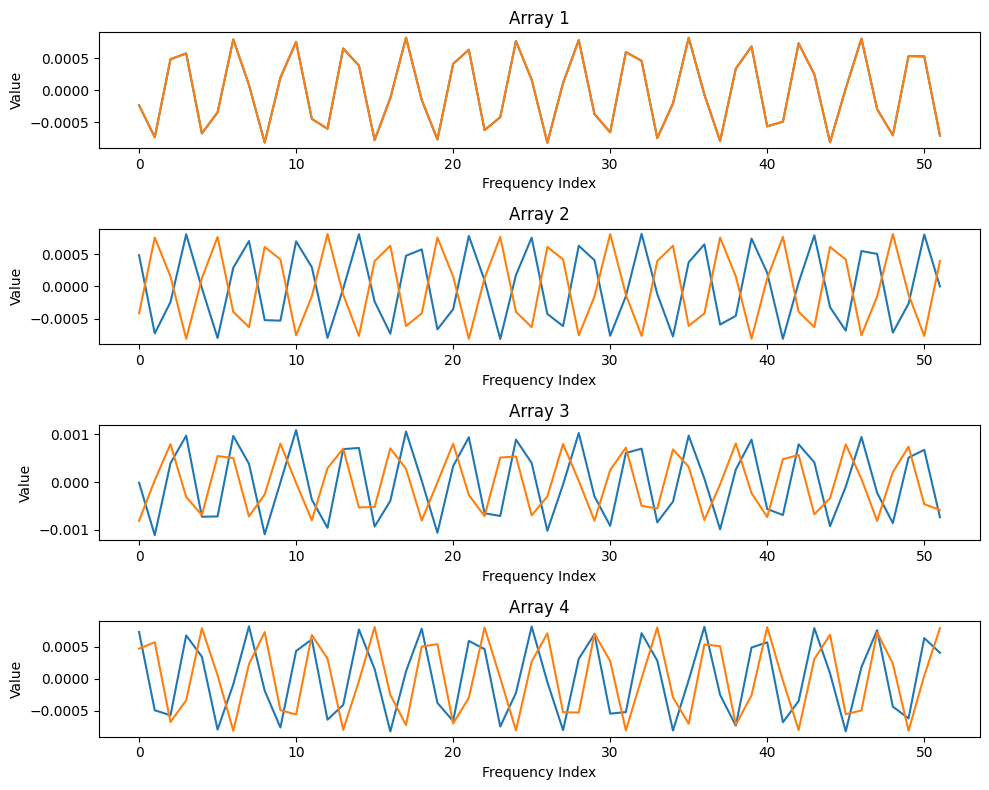

bloc rss: [-14.585332 -14.585332]
[0.83794075 0.83794075]
colors: [array([0.32411849, 0.        , 0.67588151]), array([0.32411849, 0.        , 0.67588151])]
wave number k 44.85108346976599 F0 2140000000.0 C_SPEED 299792458
DX[[0.]
 [0.]
 [0.]
 [0.]]
DY[[ 0.  ]
 [-0.06]
 [-0.03]
 [-0.09]]
***********************A[[1.        +0.00000000e+00j 1.        +0.00000000e+00j
  1.        +0.00000000e+00j ... 1.        +0.00000000e+00j
  1.        +0.00000000e+00j 1.        +0.00000000e+00j]
 [1.        +3.29560415e-16j 0.99889117+4.70789617e-02j
  0.9955685 +9.40391562e-02j ... 0.9955685 -9.40391562e-02j
  0.99889117-4.70789617e-02j 1.        -3.29560415e-16j]
 [1.        +1.64780207e-16j 0.99972275+2.35460089e-02j
  0.99889151+4.70717566e-02j ... 0.99889151-4.70717566e-02j
  0.99972275-2.35460089e-02j 1.        -1.64780207e-16j]
 [1.        +4.94340622e-16j 0.99750571+7.05858096e-02j
  0.99003833+1.40798073e-01j ... 0.99003833-1.40798073e-01j
  0.99750571-7.05858096e-02j 1.        -4.94340622e-

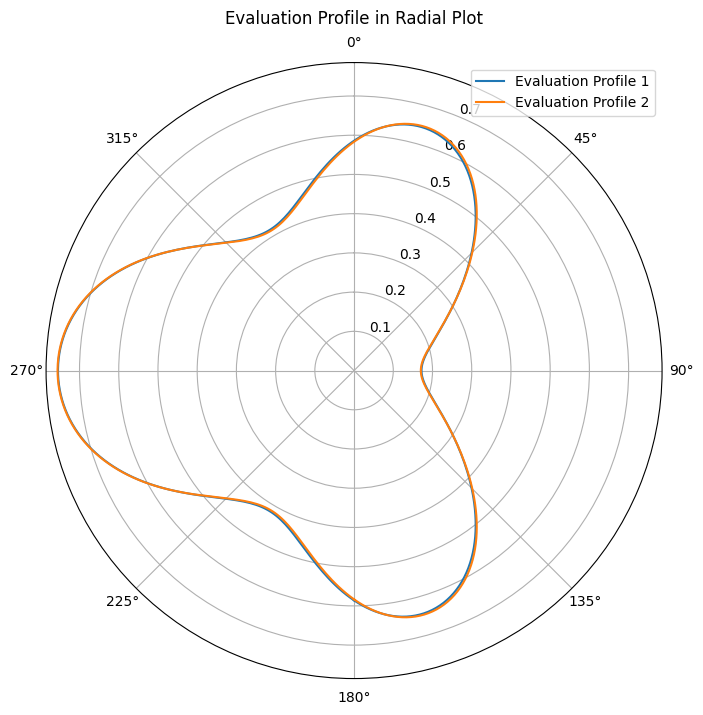

Renderer(camera=PerspectiveCamera(aspect=1.31, children=(DirectionalLight(intensity=0.25, position=(0.0, 0.0, …

In [6]:
# Compute propagation paths
# sionna.rt.Scene.compute_paths(self, max_depth=3, method='fibonacci', num_samples=1000000, los=True, reflection=True, 
#                               diffraction=False, scattering=False, ris=True, scat_keep_prob=0.001, edge_diffraction=False, 
#                               check_scene=True, scat_random_phases=True, testing=False)
paths = scene.compute_paths(max_depth=5,
                            num_samples=1e6,  # Number of rays shot into directions defined
                                              # by a Fibonacci sphere , too few rays can
                                              # lead to missing paths
                            los=True,  # Include Line-of-Sight paths
                            reflection=True,  # Include reflection paths
                            # diffraction=True,  # Include diffraction paths
                            # scattering=True,  # Include scattering paths
                            )

paths.normalize_delays = False

# Determine subcarrier frequencies
rg = ResourceGrid(num_ofdm_symbols=1,
                fft_size=52,
                dc_null = True,
                cyclic_prefix_length=20,
                #   pilot_pattern = "kronecker",
                #   pilot_ofdm_symbol_indices = [2, 8],
                subcarrier_spacing=5e6) #30e3)

frequencies = subcarrier_frequencies(rg.fft_size, rg.subcarrier_spacing)

# Reshape to [1, num_subcarriers]
h_sim = tf.reshape(cir_to_ofdm_channel(frequencies, *paths.cir()), [1, -1])
h_sim = cir_to_ofdm_channel(frequencies, *paths.cir())
print(f'h_sim.shape {h_sim.shape}')
# get rss
a, tau = paths.cir()
# del paths
csi = cir_to_ofdm_channel(frequencies, a, tau, normalize=False)  # Non-normalized includes path-loss
print(f"csi.shape {csi.shape}")
# Assuming csi is the array with shape (1, 1, 4, 1, 1, 1, 52)
# Reshape csi to (4, 52)
csi_reshaped = np.array(csi[:,0,:,:,:,:,:]).reshape(4, 52)
csi_reshaped2 = np.array(csi[:,1,:,:,:,:,:]).reshape(4, 52)
# Create a figure with 4 subplots
fig, axs = plt.subplots(4, 1, figsize=(10, 8))

# Plot each array in a separate subplot
for i in range(4):
    axs[i].plot(csi_reshaped[i])
    axs[i].set_title(f'Array {i+1}')
    axs[i].set_xlabel('Frequency Index')
    axs[i].set_ylabel('Value')

# Plot each array in a separate subplot
for i in range(4):
    axs[i].plot(csi_reshaped2[i])
    axs[i].set_title(f'Array {i+1}')
    axs[i].set_xlabel('Frequency Index')
    axs[i].set_ylabel('Value')

# Adjust layout
plt.tight_layout()
plt.show()

#Output: h_f ([batch size, num_rx, num_rx_ant, num_tx, num_tx_ant, num_time_steps, fft_size], tf.complex) – Channel frequency responses at frequencies
block_rss = get_rss_from_csi(csi).numpy()[0, :, 0, 0, 0, 0]
block_rss[np.isneginf(block_rss)] = -90
# Define range
min_rss = -90
max_rss = 0

# Normalize values to 0-1
normalized = (block_rss - min_rss) / (max_rss - min_rss)
print(f'bloc rss: {block_rss}')
print(normalized)
# Define three colors
color_black = np.array([0, 0, 0])
color_red = np.array([1, 0, 0])
color_blue = np.array([0, 0, 1])
colors = []
for value in normalized:
    if value <= 0.5:
        # Scale between black and gray
        color = color_black + (color_red - color_black) * (value / 0.5)
    else:
        # Scale between gray and white
        color = color_red + (color_blue - color_red) * ((value - 0.5) / 0.5)
    colors.append(color)
print(f'colors: {colors}')
# Map normalized values to colors
# 0-1 range is split into 3 intervals: [0, 1/3), [1/3, 2/3), [2/3, 1]
# color_indices = np.digitize(normalized, bins=[1/3, 2/3], right=False)
# mapped_colors = [colors[idx] for idx in color_indices]
# for i, rx in enumerate(rxs):
#     rx.color = colors[i] # Change color to red
# 
antenna_positions = np.array([[ 0.  ,  0.  ,  0.  ],
       [ 0.  , -0.06,  0.  ],
       [ 0.  , -0.03,  0.  ],
       [ 0.  , -0.09,  0.  ]])

# Implementing Capon Algorithim
params = Params(antenna_positions[:, :2])
# channel is 155, bandwidth is 80
# print(h_sim[:,0,:,:,:,:,:].shape)
# print(tf.reshape(h_sim[:,0,:,:,:,:,:], [1, -1]).shape)

# Create a radial plot
plt.figure(figsize=(8, 8))
ax = plt.subplot(111, projection='polar')
for i in range(0, 2): #h_sim.shape[1]):
    
    AOA, theta_samples, profile_norm = Capon(params, 155, 80, tf.reshape(h_sim[:,i,:,:,:,:,:], [1, -1])).evaluate()
    AOA = np.array([AOA])

    print(f'Plotting profile for receiver {i} with AOA {AOA}')
    # Plot the evaluation profile
    ax.plot(theta_samples, profile_norm, label=f"Evaluation Profile {i+1}")


# Add labels and legend
ax.set_title("Evaluation Profile in Radial Plot", va='bottom')
ax.set_theta_zero_location("N")  # Zero angle at the top (North)
ax.set_theta_direction(-1)  # Clockwise angle direction

# Show plot
plt.legend()
plt.show()
# AOA=np.array([Capon(params, 155, 80, h_sim).evaluate()])

csi_reading = watts_to_dbm(tf.abs(h_sim.numpy().flatten()))

# scene.preview(show_orientations=True) # Use the mouse to focus on the visualized paths
scene.preview(paths, show_devices=True, show_paths=True, show_orientations=True) # Use the mouse to focus on the visualized paths

Shape of tau:  (1, 2, 4, 1, 1, 2)
Shape of tau:  (2,)
[       nan 0.00081796 0.                nan]
[       nan 0.00081903 0.                nan]
[       nan 0.0008185  0.00036315        nan]
[       nan 0.00081957 0.                nan]


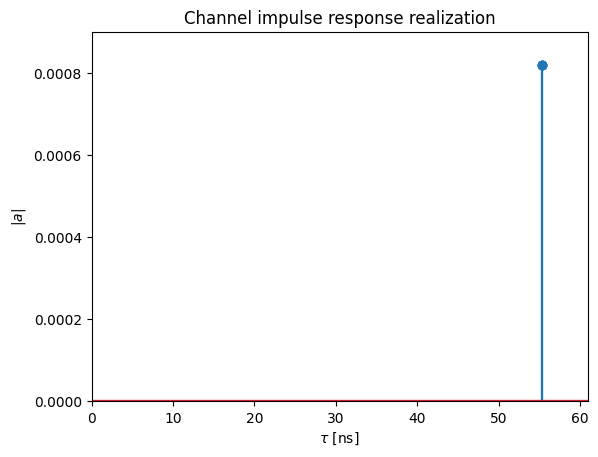

In [7]:
# print(csi_reading)
a, tau = paths.cir()

t = tau[0,0,0,0,0,:]/1e-9 # Scale to ns
print("Shape of tau: ", tau.shape)
a_abs_1 = np.abs(a)[0,0,0,0,0,:,0]
a_abs_2 = np.abs(a)[0,0,1,0,0,:,0]
a_abs_3 = np.abs(a)[0,0,2,0,0,:,0]
a_abs_4 = np.abs(a)[0,0,3,0,0,:,0]
print("Shape of tau: ", a_abs_1.shape)
a_max = np.max(a_abs_1)
# Add dummy entry at start/end for nicer figure
t = np.concatenate([(0.,), t, (np.max(t)*1.1,)])
a_abs_1 = np.concatenate([(np.nan,), a_abs_1, (np.nan,)])
a_abs_2 = np.concatenate([(np.nan,), a_abs_2, (np.nan,)])
a_abs_3 = np.concatenate([(np.nan,), a_abs_3, (np.nan,)])
a_abs_4 = np.concatenate([(np.nan,), a_abs_4, (np.nan,)])

# And plot the CIR
plt.figure()
plt.title("Channel impulse response realization")

plt.stem(t, a_abs_1)
plt.stem(t, a_abs_2)
plt.stem(t, a_abs_3)
plt.stem(t, a_abs_4)
print(a_abs_1)
print(a_abs_2)
print(a_abs_3)
print(a_abs_4)
plt.xlim([0, np.max(t)])
plt.ylim([-2e-6, a_max*1.1])
plt.xlabel(r"$\tau$ [ns]")
plt.ylabel(r"$|a|$");

# Shape of tau:  (1, 1, 4, 1, 1, 2)
# Shape of tau:  (2,)
# [       nan 0.00081796 0.00034698        nan]
# [       nan 0.00081688 0.00034815        nan]
# [       nan 0.00081742 0.00034756        nan]
# [       nan 0.00081634 0.00034874        nan]
